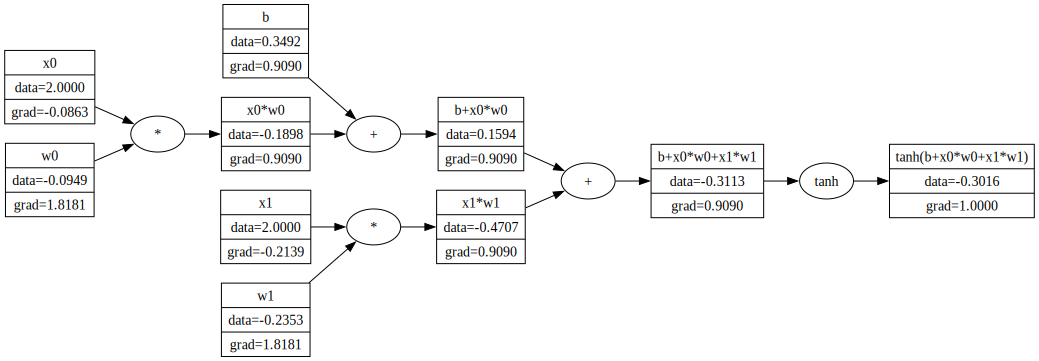

In [1]:
from graphviz import Digraph
from collections import deque
from predictors import Neuron
from value import Value


class GraphDrawer:

    def __init__(self):
        self.node_to_id = {}
        self.dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
    def get_graph(self, root):
        q = deque()
        visited = set()
        q.append(root)
        visited.add(root)
        while len(q) != 0:
            cur = q.popleft()
            self.dot.node(name=self.get_id(cur), label=str(cur), shape='record')
            cur_id_with_op = self.get_id(cur) + cur.op
            if cur.op:
                self.dot.edge(cur_id_with_op, self.get_id(cur))
                self.dot.node(name=cur_id_with_op, label=cur.op)
                
            for child in cur.children:
                self.dot.edge(self.get_id(child), cur_id_with_op)
                if child not in visited:
                    q.append(child)
                    visited.add(child)
                
    def get_id(self, node):
        if node not in self.node_to_id:
            self.node_to_id[node] = len(self.node_to_id)
        return str(self.node_to_id[node])
    
    def draw(self, node):
        g = self.get_graph(node)
        return self.dot

# create a neuron and run a backward pass
n = Neuron(2)
o = n([2, 2])
o.backward()

# draw the graph for that neuron
d = GraphDrawer()
d.draw(o)

In [2]:
import random
import numpy as np
np.random.seed(1337)
random.seed(1337)

# make up a dataset
from sklearn.datasets import make_moons, make_classification
NUM_SAMPLES = 100
X, Y = make_moons(n_samples=NUM_SAMPLES, noise=0.1)
# X = [(-1, -1), (0, 0), (1, 1), (2, 2)]
# Y = [-1, -1, 1, 1]
# X, Y = make_classification(n_samples = NUM_SAMPLES, n_features=2, n_redundant=0,n_classes=2)

Y = Y*2 - 1 # make Y -1 or 1




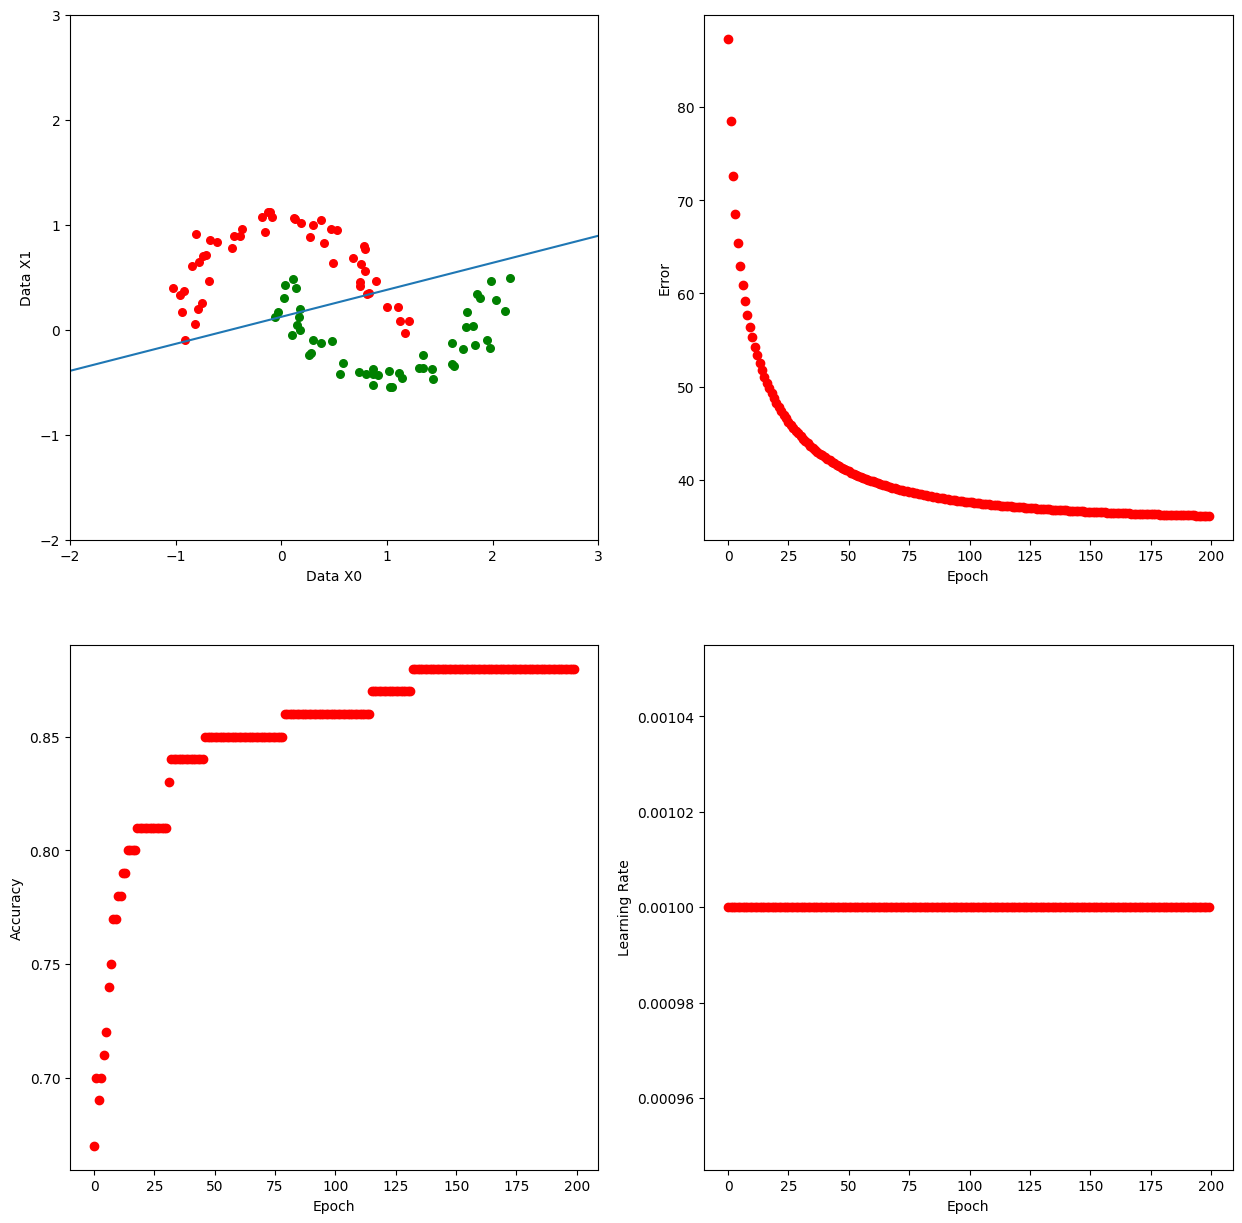

In [3]:
from IPython.display import display, clear_output
from matplotlib import pyplot as plt 
from value import Value
from predictors import Neuron

def get_loss(prediction_value, y_value):
    diff = prediction_value - y_value;
    prod = diff ** 2
    return prod

def get_loss1(prediction_value, y_value):
    f1 = lambda x: (x + 1) / 2.0
    f2 = lambda x: (-x + 1) / 2.0
    pred1 = f1(prediction_value)
    pred2 = f2(prediction_value)
    pred1_ln = pred1.ln()
    pred2_ln = pred2.ln()
    product1 = f1(y_value) * pred1_ln
    product2 = f2(y_value) * pred2_ln
    return -(product1 + product2)

def train(X, Y, n, plotter):
    EPOCHS = 200
    DELTA = 0.001
    
    for k in range(EPOCHS):
        # run a foward pass
        error = Value(0, label='error')
        correct_predictions = 0.0
        incorrect_predictions = 0.0
        for index, (x, y) in enumerate(zip(X, Y)):
            neuron_value = n([x[0], x[1]])
            y_value = Value(y, label='y')
            error = get_loss(neuron_value, y_value) + error
            if y_value.data < 0 and neuron_value.data < 0:
                correct_predictions += 1
            elif y_value.data > 0 and neuron_value.data > 0:
                correct_predictions += 1
            else:
                incorrect_predictions += 1
        
        # run a backward pass
        error.backward()
    
        # adjust the weights
        for p in n.parameters():
            # direction = 1 if p.grad >= 0 else -1
            p.data = p.data - DELTA * p.grad

        # reset the gradients
        for p in n.parameters():
            p.grad = 0

        # get the x-intercept and y-intercept to show the decision boundary
        [w0, w1, b] = n.parameters()
        x_intercept = -b.data / w0.data
        y_intercept = -b.data / w1.data
        
        # visualize the decision boundary
        plotter.show_decision_boundary_and_stats(n, error, k, correct_predictions, incorrect_predictions, DELTA, x_intercept, y_intercept)



class Plotter:

    def __init__(self, X, Y):
        # Create a figure for visualization the data
        self.fig, ax = plt.subplots(2, 2, figsize=(15, 15))

        # figure to show the decision boundary
        self.decision_boundary_plot = ax[0][0]
        self.decision_boundary_plot.set_xlim([-2, 3])
        self.decision_boundary_plot.set_ylim([-2, 3])
        self.decision_boundary_plot.set_xlabel("Data X0")
        self.decision_boundary_plot.set_ylabel("Data X1")

        # figure to show the error plot
        self.error_plot = ax[0][1]
        self.error_plot.set_xlabel("Epoch")
        self.error_plot.set_ylabel("Error")

        # figure to show accuracy
        self.accuracy_plot = ax[1][0]
        self.accuracy_plot.set_xlabel("Epoch")
        self.accuracy_plot.set_ylabel("Accuracy")

        # figure to show learning rate
        self.learning_rate_plot = ax[1][1]
        self.learning_rate_plot.set_xlabel("Epoch")
        self.learning_rate_plot.set_ylabel("Learning Rate")
        
        # Show the scatter plot for the input data
        for (x, y) in zip(X,Y):
            color = 'red' if y == -1 else 'green'
            self.decision_boundary_plot.scatter(x[0], x[1], c=color, s=30)
        self.decision_boundary_line = self.decision_boundary_plot.axline([0, 0], [0, 0])

        
        
    def show_decision_boundary_and_stats(self, predictor, error, k, correct_predictions, incorrect_predictions, learning_rate, x_intercept, y_intercept):
        # update the decision boundary
        self.decision_boundary_line.set_xy1(x_intercept, 0)
        self.decision_boundary_line.set_xy2(0, y_intercept)
                     
        # update the error
        self.error_plot.plot(k, error.data, 'ro')

        # update the accuracy
        accuracy = (correct_predictions) / (correct_predictions + incorrect_predictions)
        self.accuracy_plot.plot(k, accuracy, 'ro')

        # update the learning rate
        self.learning_rate_plot.plot(k, learning_rate, 'ro')
    
        clear_output(wait=True)
        display(self.fig)

    def close(self):
        plt.close()
    

# create a plotter to visualize the training process
plotter = Plotter(X, Y)

# create a neuron
n = Neuron(2)

# Train the neuron with these hyper-parameters
train(X, Y, n, plotter)

# Close plotter when done
plotter.close()  